# LU decomposition of structured matrices

The algorithm for computing the LU decomposition of a matrix can be adapted to matrices with special sparsity patterns. As usual, this amounts to removing unnecessary operations, which are all those arithmetic operations whose result is known in advance: sums of zeros (the result is zero), sums where one of the operands is a zero (the result is the nonzero term), multiplications by one (the result is the other factor) or by zero (the result is zero), divisions by one (the result is the dividend), or division with 0 dividend (the result is zero).

## Packages

As usual, we will deal with `numpy` matrices and vectors, thus we will need to import that package. We will look at some BLAS implementations in `scipy.linalg`, and we will use `timeit` to time our implementations and `matplotlib.pyplot` to plot the results.

In [1]:
import numpy as np
from numpy.lib import stride_tricks

import scipy as sp
from scipy import linalg

import matplotlib
from matplotlib import pyplot as plt

import timeit

## Banded arrowhead matrices

Arrowhead matrices are structured square matrices that only have nonzeros in the top row, leftmost column, and main diagonal. Computing the LU decomposition without pivoting of these matrices would only require one step of the "Gaussian elimination algorithm", and would not make for a very interesting exercise. Therefore, we will consider the family $\mathcal S_{m,k}$, where $m$ and $k$ are positive integers, with $k < \left\lfloor m/2 \right\rfloor$. The $m$-by-$m$ matrix $A$ belongs to $\mathcal S_{m,k}$ if $a_ij = 0$ when:
+ $j + k - 1 < i < m - k + 1$, or
+ $i < j < m - k + 1$.

In the cell below, you will find an implementation of a function that generates test matrix with such structure, which we will call *banded arrowhead* for short.

In [2]:
def generate_banded_arrowhead(m, k):
    """ Generate a banded arrowhead matrix with random
        entries.
    """
    assert(k < m/2)
    A = np.zeros([m, m])
    A[m-k:m,:] = np.random.rand(k, m)
    A[0:m-k,m-k:m] = np.random.rand(m-k, k)
    size_block_11 = max(0, m-k)
    if size_block_11 > 0:
        A[:m-k,:m-k] = sp.linalg.toeplitz(
            np.concatenate((np.random.rand(min(k, size_block_11)), np.zeros(max(0, size_block_11-k)))),
            np.concatenate((np.random.rand(1,), np.zeros(max(m-k-1, 0)))))
    return A

We can print a small matrix, to get a sense of the what the pattern looks like.

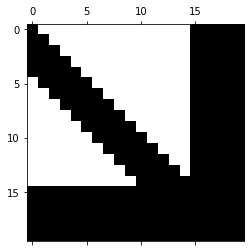

In [3]:
m = 20
k = 5
A = generate_banded_arrowhead(m, k)
plt.spy(A)
plt.show()

Let us try to solve a linear system with a coefficient in $\mathcal S_{m,k}$ with the LU decomposition without pivoting. Using pivoting here would be a good idea in general, but it would destroy the structure in $L$ and $U$, which we want to preserve in order to develop good algorithms. In the experiments below, we will generate matrices for which we can guarantee that the LU decomposition without pivoting is stable.

The first task is the implementation of a the algorithm that computes the LU decomposition in place. You should try to avoid any unnecessary operations. In order to exploit the structure, we need to know the parameter $k$. Even though we could in principle recover this by finding for the first zero entry in the first column of the matrix, we pass it as an argument for simplicity.

In [4]:
def compute_LU_banded_arrowhead(A, k):
    """ Compute the LU decomposition using a single-loop approach
        based on outer products. The algorithm requires a
        quadratic amount of additional memory.
    """
    ### BEGIN SOLUTION
    (m, n) = A.shape
    assert(m == n)
    U = A.copy()
    L = np.eye(m)

    for n in range(m-2*k):
        L[n+1:n+k, n] = U[n+1:n+k, n] / U[n, n]
        U[n+1:n+k, n] = 0
        U[n+1:n+k, m-k:m] -= np.outer(L[n+1:n+k, n], U[n, m-k:m])
        
        L[m-k:m, n] = U[m-k:m, n] / U[n, n]
        U[m-k:m, n] = 0
        U[m-k:m, m-k:m] -= np.outer(L[m-k:m, n], U[n, m-k:m])
    
    for n in range(m-2*k, m-1):
        L[n+1:m, n] = U[n+1:m, n] / U[n, n]
        U[n+1:m, n] = 0
        U[n+1:m, max(m-k,n+1):m] -= np.outer(L[n+1:m, n], U[n, max(m-k,n+1):m])
    return L, U
    ### END SOLUTION

We can test this function on small banded arrowhead matrices generated with the `generate_banded_arrowhead` function deinfed above. In order to check that the 

In [5]:
def test_LU_decomposition(m, k, f):
    """ Check that L and U computed by `f`
        satisfy LU = A.
    """
    A = generate_banded_arrowhead(m, k) + m * np.eye(m)
    L, U = f(A, k)
    if np.allclose(L @ U, A):
        return True
    else:
        return False

def run_sanity_check_LU_decomposition(f):
    """ Run basic correctness test on the function `f`.
        The latter should be a pointer to a function that
        returns two matrices, the L and U factors of the
        LU decomposition of the input.
    """
    for m in range(1, 10):
        for k in range(1, m//2):
            assert(test_LU_decomposition(m, k, f))

f = compute_LU_banded_arrowhead
run_sanity_check_LU_decomposition(f)

Next step will be to convert `compute_LU_banded_arrowhead` to work in place by modifying the matrix `A` rather than generating two new matrices `L` and `U`. As usual, your functions should modify the input and not return anything.

In [6]:
def compute_LU_banded_arrowhead_in_place(A, k):
    """ Compute the LU decomposition using a single-loop approach
        based on outer products. The algorithm requires a
        quadratic amount of additional memory.
    """
    ### BEGIN SOLUTION
    (m, n) = A.shape
    assert(m == n)

    for n in range(m-2*k):
        A[n+1:n+k, n] = A[n+1:n+k, n] / A[n, n]
        A[n+1:n+k, m-k:m] -= np.outer(A[n+1:n+k, n], A[n, m-k:m])
        
        A[m-k:m, n] = A[m-k:m, n] / A[n, n]
        A[m-k:m, m-k:m] -= np.outer(A[m-k:m, n], A[n, m-k:m])
    
    for n in range(m-2*k, m-1):
        A[n+1:m, n] = A[n+1:m, n] / A[n, n]
        A[n+1:m, max(m-k,n+1):m] -= np.outer(A[n+1:m, n], A[n, max(m-k,n+1):m])
    ### END SOLUTION

In [7]:
def test_LU_decomposition(m, k, f):
    """ Check that L and U computed by `f`
        satisfy LU = A.
    """
    A = generate_banded_arrowhead(m, k) + m * np.eye(m)
    B = A.copy()
    f(B, k)
    L = np.eye(m) + np.tril(B, -1)
    U = np.triu(B)
    if np.allclose(L @ U, A):
        return True
    else:
        return False

def run_sanity_check_LU_decomposition(f):
    """ Run basic correctness test on the function `f`.
        The latter should be a pointer to a function that
        returns two matrices, the L and U factors of the
        LU decomposition of the input.
    """
    for m in range(1, 10):
        for k in range(1, m//2):
            assert(test_LU_decomposition(m, k, f))

f = compute_LU_banded_arrowhead_in_place
run_sanity_check_LU_decomposition(f)

Next, we want to use the function defined above to solve a structured linear system. In order to do that, we need to define a structured version of the algorithms for backward and forward substitution.

In [8]:
def solve_banded_arrowhead_upper_triangular_system(U, k, b):
    assert(is_numpy_matrix(U) and is_numpy_vector(b))
    (m, n) = U.shape
    assert(m == n)
    assert(m == b.shape[0])
    ### BEGIN SOLUTION
    x = np.zeros_like(b)
    for i in range(m-1, -1, -1):
        x[i] = b[i]
        x[i] -= U[i, max(m-k, i+1):m] @ x[max(m-k, i+1):m]
        x[i] /= U[i, i]
    return x
    ### END SOLUTION

def solve_banded_arrowhead_unit_lower_triangular_system(L, k, b):
    assert(is_numpy_matrix(L) and is_numpy_vector(b))
    (m, n) = L.shape
    assert(m == n)
    assert(m == b.shape[0])
    ### BEGIN SOLUTION
    x = np.zeros_like(b)
    for i in range(m-k):
        x[i] = b[i]
        x[i] -= L[i, max(0, i-k):i] @ x[max(0, i-k):i]
    for i in range(m-k, m):
        x[i] = b[i]
        x[i] -= L[i, 0:i] @ x[0:i]
    return x
    ### END SOLUTION

We can now define a function that solves the linear system by relying on the three functions defined above.

In [9]:
def is_numpy_matrix(A):
    if type(A) != np.ndarray or A.ndim != 2:
        return False
    else:
        return True
    
def is_numpy_vector(x):
    if type(A) != np.ndarray or (A.ndim > 2 and x.shape[1] != 1):
        return False
    else:
        return True

def solve_banded_arrowhead_linear_system_lu(A, k, b):
    # Validate input.
    if not is_numpy_matrix(A):
        raise Exception("The first argument must be a numpy matrix.")
    (m, n) = A.shape
    if m != n:
        raise Exception("The first argument must be a square matrix.")
    if not is_numpy_vector(b):
        raise Exception("The second argument must be a numpy vector or column matrix.")
    if m != b.shape[0]:
        raise Exception("First and second argument must be conformable.")
    
    ### BEGIN SOLUTION
    compute_LU_banded_arrowhead_in_place(A, k)
    y = solve_banded_arrowhead_unit_lower_triangular_system(A, k, b)
    x = solve_banded_arrowhead_upper_triangular_system(A, k, y)
    return x
    ### END SOLUTION

Finally, we can test that the functions work as intended.

In [10]:
def test_LU_solver(m, k, f):
    """ Compare the result computed by the function `f`
        by the built-in operator `numpy.linalg.solve`.
    """
    A = generate_banded_arrowhead(m, k) + m * np.eye(m)
    b = np.random.rand(m)
    reference = np.linalg.solve(A, b)
    if np.allclose(f(A, k, b), reference):
        return True
    else:
        print("ref = ", reference)
        print("f   = ", f(A, k, b))
        return False

def run_sanity_check(f):
    """ Run basic correctness test on the function `f`.
        The latter should be a pointer to a function that
        takes a banded arrowhead matrix `A`, its band `k`,
        and a vector `b`, and solves the linear system
        `A x = b`.
    """
    for m in range(1, 10):
        for k in range(1, m//2):
            assert(test_LU_solver(m, k, f))

f = solve_banded_arrowhead_linear_system_lu
run_sanity_check(f)